### __Init__

In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

import networkx as nx 
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm


import random
import matplotlib.pyplot as plt
from rdkit import Chem
from dataset import create_pytorch_geometric_graph_list, create_dataloaders
from models import odorGIN
from train import train_single_epoch, test, train
import torch
from rdkit.Chem import Draw
from torch_geometric.explain import Explanation, Explainer, ModelConfig
from torch_geometric import explain
from explainer import visualize_molecule_explanation

import sys



### __Dataset__ 

In [3]:
df_path = 'data/Multi-Labelled_Smiles_Odors_dataset.csv'
odor_df = pd.read_csv(df_path)

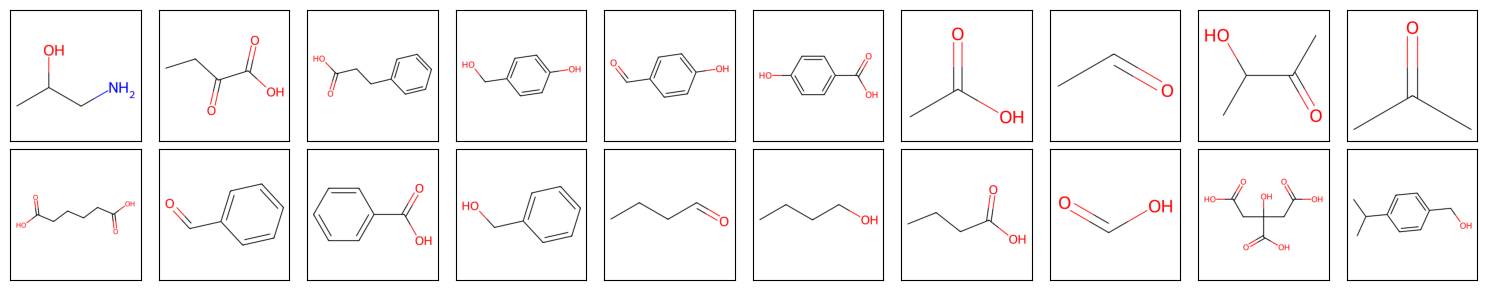

In [4]:
# Molecule Visualization 
nrows, ncols = 2, 10

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3))
for i in range(nrows*ncols):
    m = Chem.MolFromSmiles(odor_df['nonStereoSMILES'][i])
    img = Draw.MolToImage(m)
    axs[i//ncols][i%ncols].imshow(img)
    axs[i//ncols][i%ncols].set_xticks([])
    axs[i//ncols][i%ncols].set_yticks([])   
plt.xticks([])
plt.yticks([])
fig.tight_layout()
plt.show()

In [5]:
X = odor_df.iloc[:, 0]
classes = odor_df.columns[2:]
y = odor_df.iloc[:, 2:].values

graph_list = create_pytorch_geometric_graph_list(X, y)
graph_list[0: 5]


[Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[138], smiles='CC(O)CN'),
 Data(x=[7, 11], edge_index=[2, 12], edge_attr=[12, 4], y=[138], smiles='CCC(=O)C(=O)O'),
 Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[138], smiles='O=C(O)CCc1ccccc1'),
 Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[138], smiles='OCc1ccc(O)cc1'),
 Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[138], smiles='O=Cc1ccc(O)cc1')]

In [6]:
batch_size, use_shuffle = 1, True
train_set, val_set, test_set,  train_loader, val_loader, test_loader = create_dataloaders(graph_list, 0.7, 0.2, 0.1, batch_size)

# hyperparamters 
hidden_channels = 64
num_layers = 2
dropout_p = 0
pooling_type = 'mean'
in_channels = list(graph_list[0].x.shape)[-1]
out_channels = 1 
num_epochs = 50
lr = 1e-4
weight_decay = 1e-6


model_GIN = odorGIN.OdorGIN(in_channels, hidden_channels, num_layers)
optimizer = torch.optim.Adam(model_GIN.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
model_GIN

OdorGIN(
  (gnn): GIN(11, 64, num_layers=2)
  (classifier): GraphClassifier(
    (mlp): Linear(in_features=64, out_features=138, bias=True)
  )
)

In [69]:
import torch 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from utils import plot_losses
from sklearn.metrics import f1_score, roc_auc_score
# from torch_geometric.nn import save_pretrained


def plot_util(train_losses, val_losses, title=None):
    """Utility method to plot paired loss curves"""
    # print(train_accs, val_accs)
    plt.plot(range(len(val_losses)), val_losses, label='val')
    plt.plot(range(len(train_losses)), train_losses, label='train')
    plt.legend()
    plt.title(title)
    plt.show()



# WIP: Hyperparameter tuning, save best model, 

softmax_cutoff = 0.005

def train_single_epoch(model, optimizer, train_loader, mode):
    '''
    Train model for one epoch
    '''

    if mode == "train":
        model.train()
    elif mode == "val" or mode == "test":
        model.eval()

    total_loss = 0
    for data in train_loader:
        # data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = torch.nn.CrossEntropyLoss()(out.squeeze(), data.y)

        if mode == "train":
            loss.backward()
            optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)  



@torch.no_grad()
def test(model, loader):
    '''
    Test the model on test loader 
    '''

    model.eval()
    total_correct = 0
    total_ex = 0 
    all_preds = []
    all_true = [] 
    for data in loader:
        # data = data.to(device)

        pred = model(data.x, data.edge_index, data.batch)
        pred = (pred.squeeze() >= softmax_cutoff).float()


        total_correct += int((pred == data.y).sum()) 
        total_ex += np.prod(data.y.shape) 

        all_preds.append(pred)
        all_true.append(data.y)
    return total_correct / total_ex, torch.vstack(all_preds), torch.vstack(all_true)






def train_model(model, num_epochs, lr, weight_decay, train_loader, val_loader):
    '''
    Train or finetune the given model using the train/val sets
    '''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # track metrics
    roc_scores, f1_scores, train_accs, test_accs, losses, val_losses = [], [], [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        loss = train_single_epoch(model, optimizer, train_loader, 'train')
        val_loss = train_single_epoch(model, optimizer, val_loader, 'val')
        train_acc, train_preds, train_true  = test(model, train_loader)
        test_acc, test_preds, test_true = test(model, val_loader)

        # return test_accs, test_preds, test_true
    
        # track metrics
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        losses.append(loss)
        val_losses.append(val_loss)
        if( val_losses == [] or  val_loss < min(val_losses)):
            model.save_pretrained('./models/odorGIN.pth', push_to_hub=False)

    
    plot_losses(losses, val_losses, title='finetuning: train vs. val loss')
    plot_losses(train_accs, test_accs, title='finetuning: train vs. val loss')
    
    return losses, val_losses, train_accs, test_accs, f1_scores, roc_scores


100%|██████████| 50/50 [04:16<00:00,  5.13s/it]


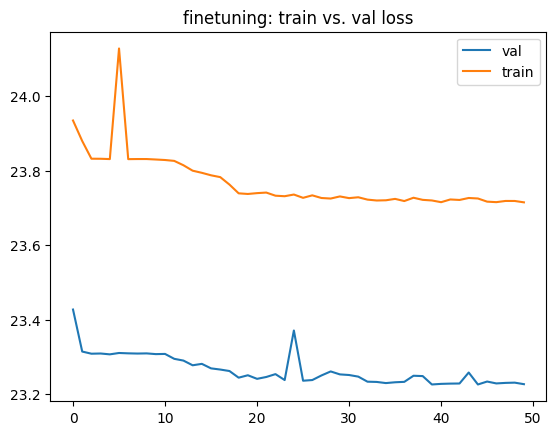

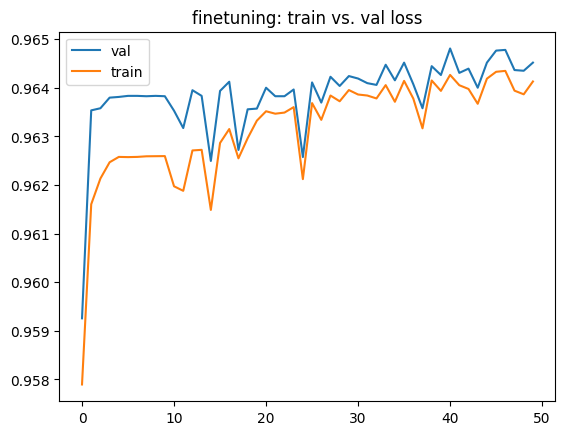

In [70]:
model = odorGIN.OdorGIN(in_channels, hidden_channels,  num_layers )
train_losses, val_losses, train_accs, test_accs, f1_scores, roc_scores = train_model(model, num_epochs, lr, weight_decay, train_loader, val_loader)


___
___

### __Hyperparameter Tuning__ 

100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


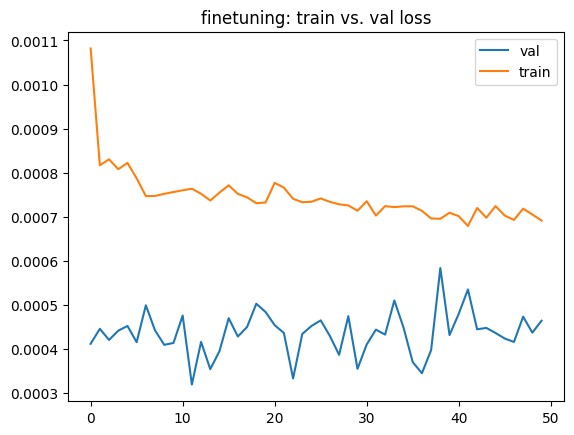

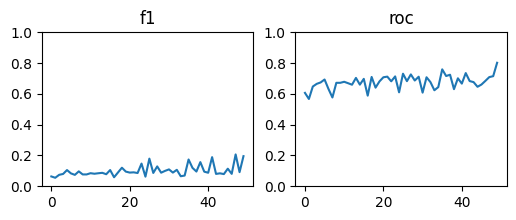

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


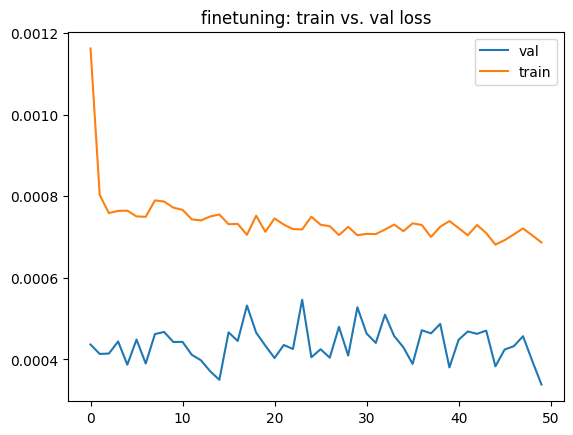

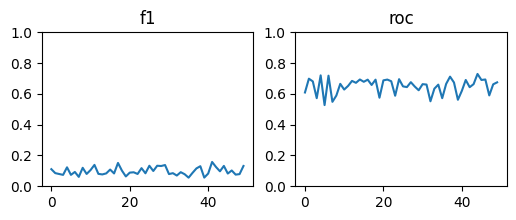

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


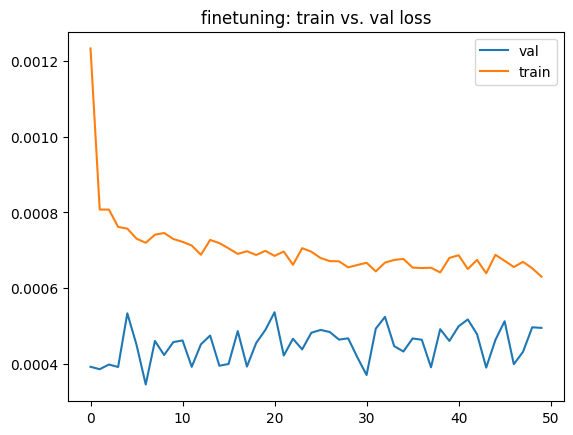

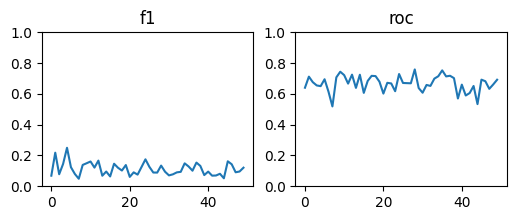

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


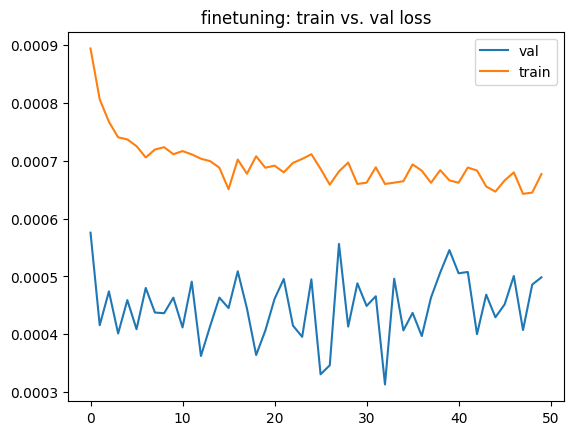

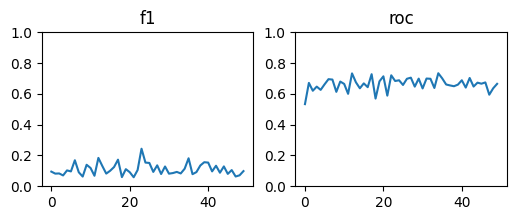

100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


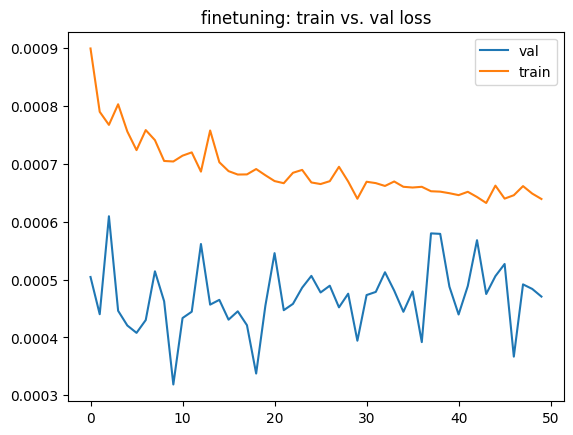

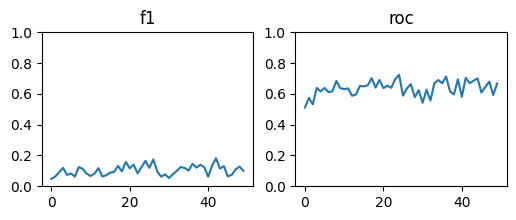

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


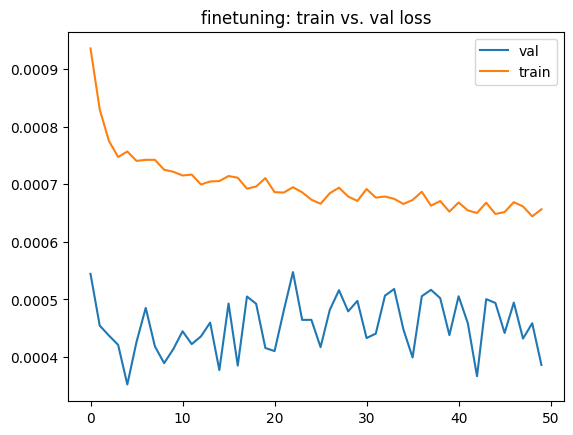

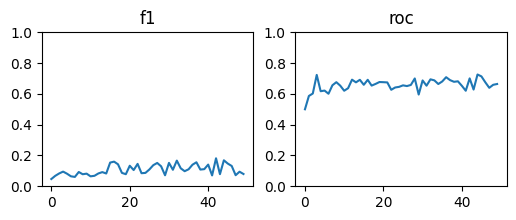

In [108]:
hyperparam_tuning = True

if hyperparam_tuning:
    import itertools 

    param_search = {
        "lr": [1e-2, 5e-3, 1e-3],
        "weight_decay": [1e-5, 1e-6],
    }

    param_search_results = []

    for lr, weight_decay in list(itertools.product(*list(param_search.values()))):
        model = ScentClassifier(
            in_channels,
            hidden_channels, 
            num_layers, 
            out_channels,
            dropout=dropout_p,
            pooling_type=pooling_type,
        )
        # model = model.to(device)

        # train
        best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning( model, num_epochs, lr, weight_decay)
        param_search_results.append( ((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch), (lr, weight_decay)) )


In [153]:


if hyperparam_tuning:
    # show best results, by F1 or AUC
    param_search_results.sort(key = lambda x: x[0][0])
    print("Best F1 score:", param_search_results[-1][0][0])
    print("Best F1 epoch:", param_search_results[-1][0][1])
    print(
        "Best F1 params:", 
        dict(zip(
            param_search.keys(),
            param_search_results[-1][-1]        
        )
    )

    param_search_results.sort(key = lambda x: x[0][2])
    print("Best AUC score:", param_search_results[-1][0][2])
    print("Best AUC epoch:", param_search_results[-1][0][3])
    print(
        "Best AUC params:", 
        dict(zip(
            param_search.keys(),
            param_search_results[-1][-1]        
        ))
    )

Best F1 score: 0.25
Best F1 epoch: 4
Best F1 params: {'lr': 0.005, 'weight_decay': 1e-05}
Best AUC score: 0.8019547325102879
Best AUC epoch: 49
Best AUC params: {'lr': 0.01, 'weight_decay': 1e-05}


### __Model Embeddings__

In [154]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings(model, graph_list, title=None, savepath=None):
    """Visualize model embeddings for graphs in graph_list via PCA and t-SNE."""
    # look just at GNN + pooling
    emb_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    )

    if model is not None:
        print('loading state dict')
        emb_model.gnn.load_state_dict(
            model.gnn.state_dict()
        )

    # generate embeddings
    coords = []
    labels = []
    for graph_data in graph_list:
        graph_data = graph_data
        readout = emb_model(graph_data.x, graph_data.edge_index, batch=torch.tensor([0]))
        coords.append(readout.squeeze())
        labels.append(graph_data.y.item())

    X = torch.vstack(coords).detach().numpy()

    pca = PCA(n_components=30)
    X_pca = pca.fit_transform(X)

    X_embedded = TSNE(n_components=2).fit_transform(X_pca)
    # X_embedded = X_pca

    labels = np.array(labels)

    plt.scatter(X_embedded[(labels==0), 0], X_embedded[(labels==0), 1], c='#fcbf49', s=35, label='not pungent', alpha=0.3)
    plt.scatter(X_embedded[(labels==1), 0], X_embedded[(labels==1), 1], c='#c1121f', s=35, label='pungent', alpha=0.3)
    plt.legend()
    # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['red' if x else 'blue' for x in labels], s=0.2)
    if title:
        plt.title(title)

    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

plot_embeddings(model, graph_list,  title='t-SNE embedding visualization: after training', savepath='tsne_embedding')

loading state dict


RuntimeError: Error(s) in loading state_dict for GIN:
	Unexpected key(s) in state_dict: "convs.0._edge_mask". 